In [2]:
import re

from matplotlib import pyplot as plt

from socketudp.hex_check import HexCheck
%load_ext autoreload
%autoreload 2

import numpy as np


from extinction_plots import plot_normalized_histogram
from extinction_functions import simulate_delta_train, get_delta_trains_from_hex, \
    get_three_fold_coincidence_points, symmetric_mod, \
    combine_periods, deep_reload, get_delta_trains_per_event_from_hex

import hex_check as hc_mod
from socketudp.hex_check_classes import NewEvent, PeakArea

# Force a clean reload order: deps first, then dependents
deep_reload("hex_check")

desired_file_path = None
# desired_file_path = "data_20251216_202608.dat"  # set to a value if you wish to specify a specific file, overrides setting in hex_check_config.py

# Rebuild the object so it picks up new config/code
hc = hc_mod.build_hex_check(plot=False, new=True, desired_file_path=desired_file_path)



# np_seterr(all='raise')


Reloaded hex_check_config
Reloaded hex_check_classes

Reloaded hex_check
ℹ️ℹ️ Info: Multiple .dat files found in the current directory. Picking this one (data_20260203_101900.dat) ℹ️ℹ️
Using input file data_20260203_101900.dat
# Peakfinding Length: 300000000
# Number of subevents: 99
# Raw Data Length: 0
# Peakfinding Threshold: -200
# Peak height event count: 200
# Peak area event count: 600
# FPGA Test Mode: 0
# ADC 0 1 2 3 Enabled: (True, True, True, True)
# top_fmc228_pcie_v27.1.bit
Found 183 events in the file.
Parsing NewEvent #1, data length 60232.
data_str starts with ffffff11000649edcff0
Found timestamp: 2026-02-03 10:20:05.007598-06:00, skipping ffffff11000649edcff0d4ee
Event 3364738-1 has timestamp 2026-02-03 10:20:05.007598-06:00
Event 3364738-1 has 99 sub-events.
Parsing NewEvent #2, data length 60232.
data_str starts with ffffff11000649edd1a8
Found timestamp: 2026-02-03 10:20:33.796895-06:00, skipping ffffff11000649edd1a81f1f
Event 3364837-2 has timestamp 2026-02-03 10:2

In [3]:
from socketudp.extinction_plots import plot_raw_data

# plot_raw_data(hc, event_range=(0,5), n_subevents=99, figsize=(20, 14),
#               plotting_units='raw',
#               # t_range=(1130,1330),
#               # y_range=(-0.03, 0.005),
#               )

Peak widths (n=6): mean=10 samples, median=10, std=2.19089
min=8, max=12


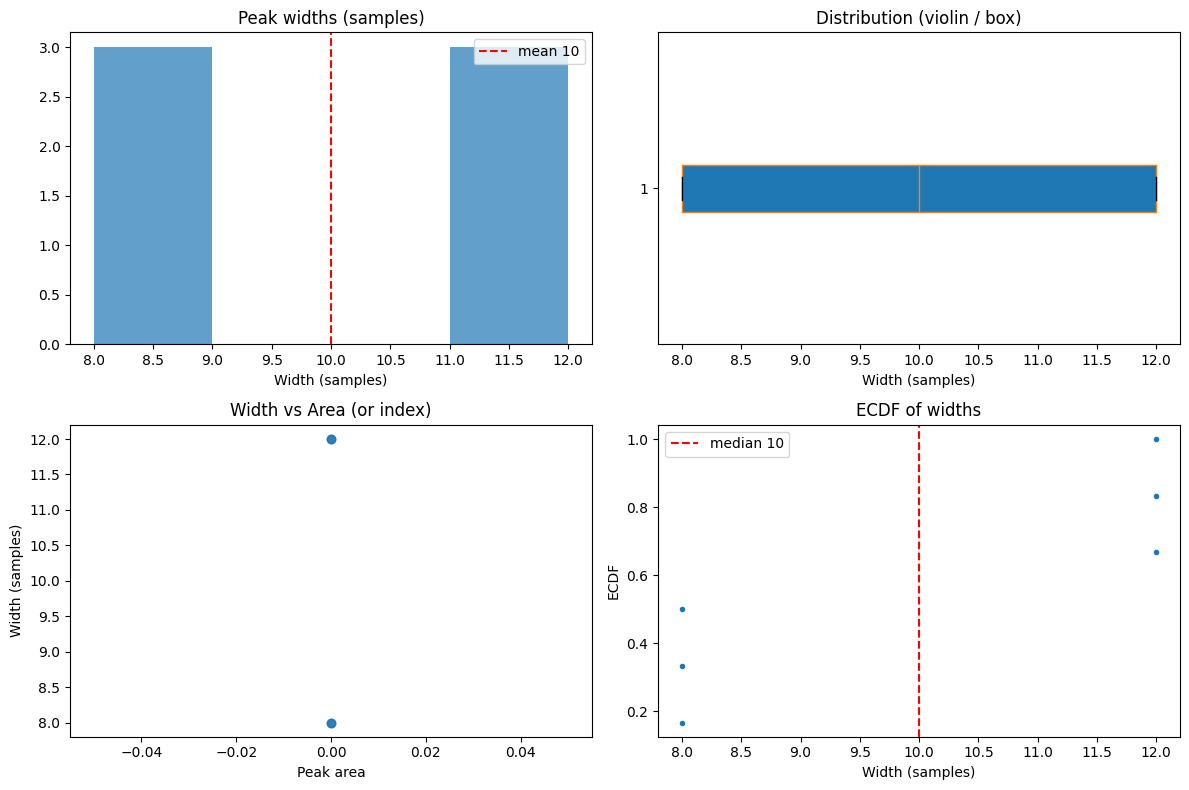

Peak widths (n=6): mean=8.5 samples, median=7.5, std=4.13521
min=5, max=16


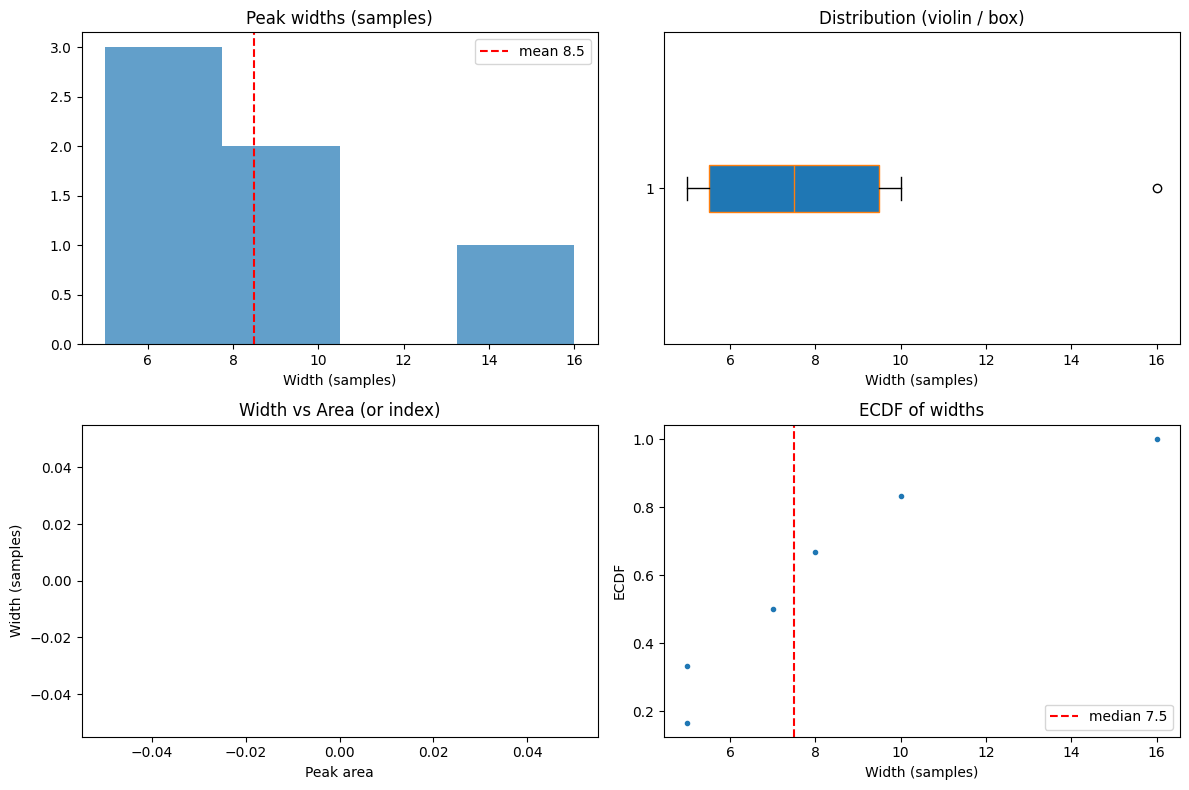

In [4]:
from socketudp.hex_check_classes import PeakHeight
from socketudp.extinction_plots import peak_width_classification

# Calculate average width in time of peaks from peak area packets

peak_areas: list[PeakArea] = []
peak_heights: list[PeakHeight] = []
for event in hc.event_buffer:
    event: NewEvent
    for subevent in event.sub_events:
        # print(subevent.peak_area_list)
        peak_areas += subevent.peak_area_list[1]
        peak_heights += subevent.peak_height_list[1]

# print(peak_areas[0], len(peak_areas))
# print(peak_heights[0], len(peak_heights))

# peak_widths = [p.peak_width for p in peak_areas]

peak_width_classification(peak_areas)
peak_width_classification(peak_heights, type="height")  # this plots peak heights, but plots will all be labeled as "width/area"

In [5]:
# last_event = hc.event_buffer[-1]
# print(f"# Events / Subevents: {last_event.internal_event_number} / {last_event.sub_event_number}")

# all times in this file are in nanoseconds unless otherwise specified
signal_period = 1 / 589.9801  # ns, the nominal period of the signal, 1694.97242 ns
sample_rate = 4  # ns, the sampling rate of the signal (4 ns per sample)

use = "real_data"  # "real_data" or "simulated_data"
# FOR SIMULATED DATA
length_ms = 30
length_ns: int = int(length_ms * 1e6)  # ns, total time for the delta train
# arrival_jitter derived based on requirement for ~99.99893% of protons within ±125 ns
arrival_jitter_ns = 27.14
particle_num_mean = 3
particle_num_width = 2
noise_num_mean = 0.1
noise_num_width = 0.15
phase_offset_deg = 0
gradual_phase_shift_speed_ns = 5  # ns, the speed of the gradual phase shift in the signal

# OTHER SETTINGS
desired_f_resolution = 0.1  # kHz, desired frequency resolution for the FFT
zero_padding_ratio = 5  # set to None to calc. zero padding based on desired_f_resolution
common_title_text = ""  # leave unfilled, is set at beginning of main()

# 4 ns sample rate
# total_time = 1695 * 501 ns = 849,195 ns = 0.849195 ms
# fs = 1 / (4e-9) = 250 MHz
# fn = fs / 2 = 125 MHz
print(f"Sampling rate (fs): {1 / sample_rate * 1e6} MHz ({sample_rate} ns)")
print(f"Nyquist frequency (fn): {1 / (2 * sample_rate) * 1e6} MHz ({2 * sample_rate} ns)")

if use == 'real_data':
    common_title_text = f"{hc.file_name}"
else:
    common_title_text = f"Simulated Delta Train (length: {length_ms} ms, "
    common_title_text += f"signal period: {signal_period} ns, sample rate: {sample_rate} ns)"

Sampling rate (fs): 250000.0 MHz (4 ns)
Nyquist frequency (fn): 125000.0 MHz (8 ns)


In [6]:
def get_delta_train(channel, fft_time_range_ns: tuple[float, float] = (None, None)):
    global common_title_text
    if use == "real_data":
        delta_train, fft_time_range_ns = get_delta_trains_from_hex(hc, channel, fft_time_range_ns)
        if delta_train.size == 0:
            return delta_train, fft_time_range_ns
        print(delta_train[0], delta_train[-1], )
        if "Time Range" not in common_title_text:
            common_title_text += (f"\nTime Range: {delta_train[0] * 1e-6:.2f} "
                                  f"to {delta_train[-1] * 1e-6:.2f} ms")
    elif use == "simulated_data":
        delta_train = simulate_delta_train(signal_period, phase_offset_deg, arrival_jitter_ns,
                                           particle_num_mean, particle_num_width, noise_num_mean,
                                           noise_num_width,
                                           length_ns, sample_rate)
        fft_time_range_ns = (delta_train[0], delta_train[-1])  # default to full range
    else:
        raise ValueError("Invalid use case. Use 'real_data' or 'simulated_data'.")

    return delta_train, fft_time_range_ns

File name: data_20260203_101900.dat
[CH1] Event 5: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 12: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 32: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 33: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 44: 1 peaks heights(1 from t = 0 to 100000000.0 ns).
[CH1] Event 73: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 74: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 83: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 93: 1 peaks heights(1 from t = 0 to 100000000.0 ns).
[CH1] Event 123: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 128: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Event 145: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH1] Received 12 delta trains
No data in specified t_range; nothing to plot.
[CH2] Event 93: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH2] Event 159: 1 peaks heights(0 from

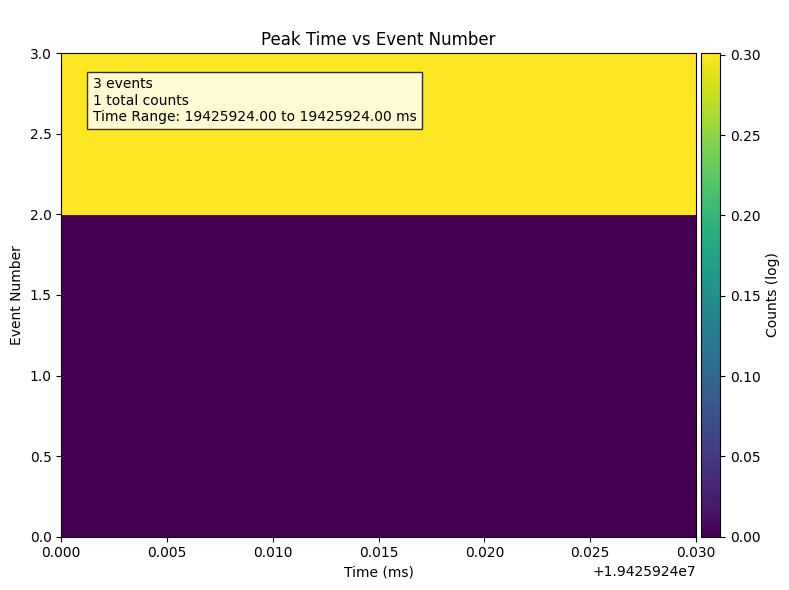

[CH3] Event 18: 1 peaks heights(1 from t = 0 to 100000000.0 ns).
[CH3] Event 21: 1 peaks heights(1 from t = 0 to 100000000.0 ns).
[CH3] Event 34: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH3] Event 93: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH3] Event 95: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH3] Event 158: 1 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH3] Received 6 delta trains


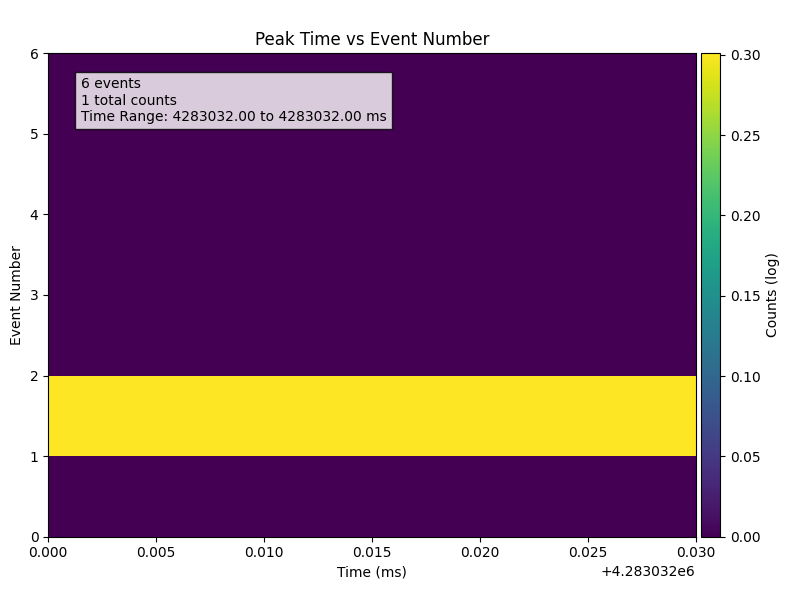

[CH4] Event 109: 248 peaks heights(248 from t = 0 to 100000000.0 ns).
[CH4] Event 110: 236 peaks heights(236 from t = 0 to 100000000.0 ns).
[CH4] Event 111: 230 peaks heights(230 from t = 0 to 100000000.0 ns).
[CH4] Event 112: 231 peaks heights(231 from t = 0 to 100000000.0 ns).
[CH4] Event 113: 215 peaks heights(215 from t = 0 to 100000000.0 ns).
[CH4] Event 114: 238 peaks heights(238 from t = 0 to 100000000.0 ns).
[CH4] Event 115: 217 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 116: 236 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 117: 232 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 118: 246 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 119: 245 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 120: 229 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 121: 232 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 122: 247 peaks heights(0 from t = 0 to 100000000.0 ns).
[CH4] Event 123: 216 peaks heights(0

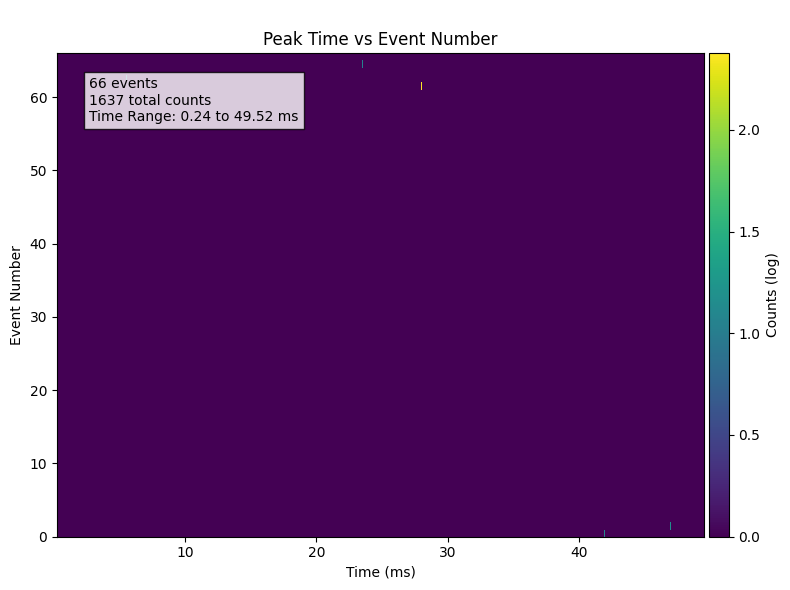

In [7]:
from extinction_plots import plot_2d_histogram_time_vs_event_number

def get_delta_train_per_event(channel: int,
                              fft_time_range_ns: tuple[float, float] = (None, None),
                              period=None):
    """
    Get delta train for a specific channel and event.
    :param channel: Channel number (1, 2, or 3).
    :param fft_time_range_ns: Time range for FFT in nanoseconds.
    :return: Delta train and time range for FFT.
    """
    r = get_delta_trains_per_event_from_hex(hc, channel, fft_time_range_ns, units='ns', period=period)
    return r

# t_range_begin_ns = 29.5e6
# t_range = (t_range_begin_ns, t_range_begin_ns + 1695*15)
t_range = (0, 100e6)
print(f"File name: {hc.file_name}")

for i in range(4):
    delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=i+1,
                                                                            fft_time_range_ns=t_range)
    print(f"[CH{i+1}] Received {len(delta_trains_per_event)} delta trains")


    plot_2d_histogram_time_vs_event_number(
        delta_trains_per_event,
        bin_width = 0.03,
        units='ms',
        t_range=(0, 50e6)
    )

    # if i == 0:
    #     plot_2d_histogram_time_vs_event_number(
    #     delta_trains_per_event,
    #     bin_width = 0.03,
    #     units='ms',
    #     t_range=(12.5e6, 17.5e6)
    # )

In [8]:
from socketudp.extinction_functions import fft

fft_range = (0e6, 40e6)
ch1, fft_range_1 = get_delta_train(1, fft_range)
# ch1 = np.array([])  # use if ch1 is just the trigger pulse
print()
ch2, fft_range_2 = get_delta_train(2, fft_range)
print()
ch3, fft_range_3 = get_delta_train(3, fft_range)
print()

chs: list[np.ndarray] = []
total_fft_range: tuple[float, float] | tuple[float, float] = (np.inf, -np.inf)
for ch in [ch1, ch2, ch3]:
    if ch.size > 0:
        chs.append(ch)
        # recalculate total min/max range with new ch
        total_fft_range = (min(total_fft_range[0], min(ch)), max(total_fft_range[1], max(ch)))

# Run three FFTs / calculate average period
periods: list[float] = []
period_errors: list[float] = []
delta_trains: list[np.ndarray] = []

for i in range(len(chs)):
    r = fft(i+1,
            chs[i],
            fft_time_range_ns = (total_fft_range[0], total_fft_range[1]),
            expected_peak_khz=590,
            sample_rate=sample_rate, desired_f_resolution=desired_f_resolution, hc=hc,
            signal_period=signal_period, length_ns=length_ns, common_title_text=common_title_text, zero_padding_ratio=zero_padding_ratio)
    delta_trains.append(r[0])
    periods.append(r[1])
    period_errors.append(r[2])
    print()

# ##########
# COMBINE PERIODS
# ##########
if not any(periods):
    raise Exception("No periods found")
period = float(np.mean(periods))
period_error = np.std(periods) / np.sqrt(len(periods))
print(f"Averaged Period: {period:.6f} ns, Error: {period_error:.6f} ns (std.dev error)")

weighted_period, final_error = combine_periods(period, periods, period_errors)

[CH1] Using real data from channel 1 with 12 events.
[CH1] First event time: 445260272.00 ns, 

[CH2] Using real data from channel 2 with 3 events.
[CH2] First event time: 339506560.00 ns, 
19425924 19425924

[CH3] Using real data from channel 3 with 6 events.
[CH3] First event time: 68036852.00 ns, 
4283032 4283032

[CH1] Total time: 0.000 ms


ZeroDivisionError: division by zero

In [ ]:
from extinction_plots import plot_1d_histogram

plot_1d_histogram(chs, common_title_text=common_title_text, hist_range=total_fft_range,
                  title=f"Full Histogram - Time Range: {total_fft_range[0] * 1e-6:.2f} to {total_fft_range[1] * 1e-6:.2f} ms",
                  fig_size=(6, 4), file_name=f"img/{hc.folder_name}/full_histogram.png", loc="upper left",
                  log=True, bin_size_ns=0.05e6, alpha=0.7)

# start = 32.5e6 - 32.5e6 % period - 500
start = 16e6
offset = 225
start = start - start % period - offset
end = start + period * 10

plot_1d_histogram(chs, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=period, hist_range=(start, end), loc="best", alpha=0.7, bin_size_ns=40,
                  fig_size = (12, 4), sample_offset=-150,
                  file_name=f"img/{hc.folder_name}/{hc.file_name}_zoomed_1d_histogram.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.2f} to {end * 1e-6:.2f} ms",
                  units='ns')


![hi](../documentation_texts/old/vladimir_beam_loss_slide_1.png)
![hi](../documentation_texts/old/vladimir_beam_loss_slide_2.png)
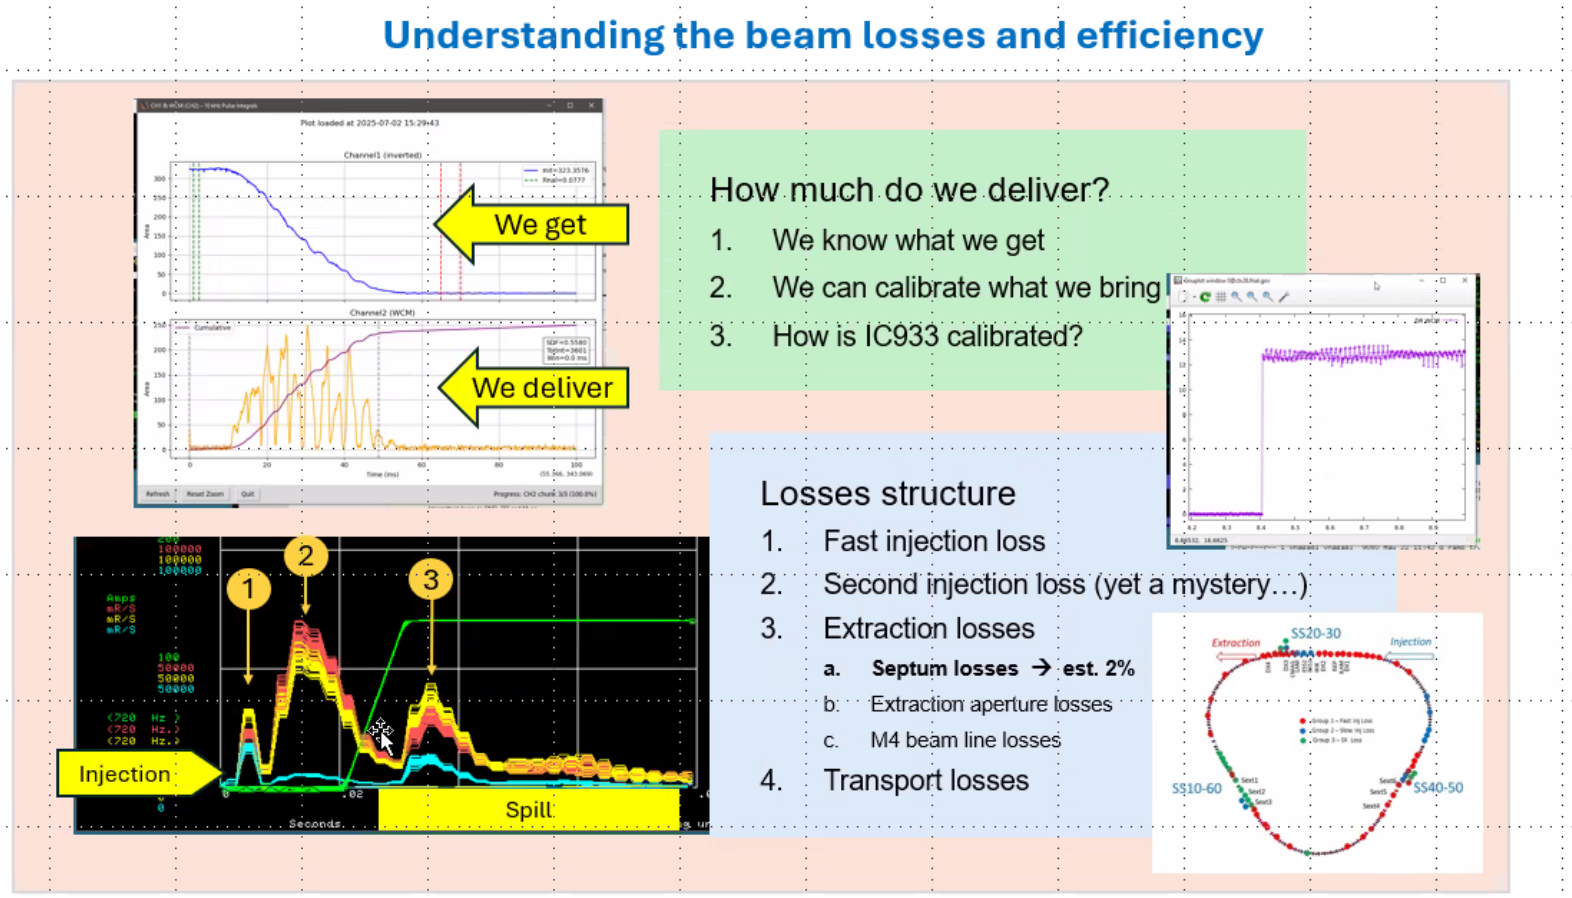
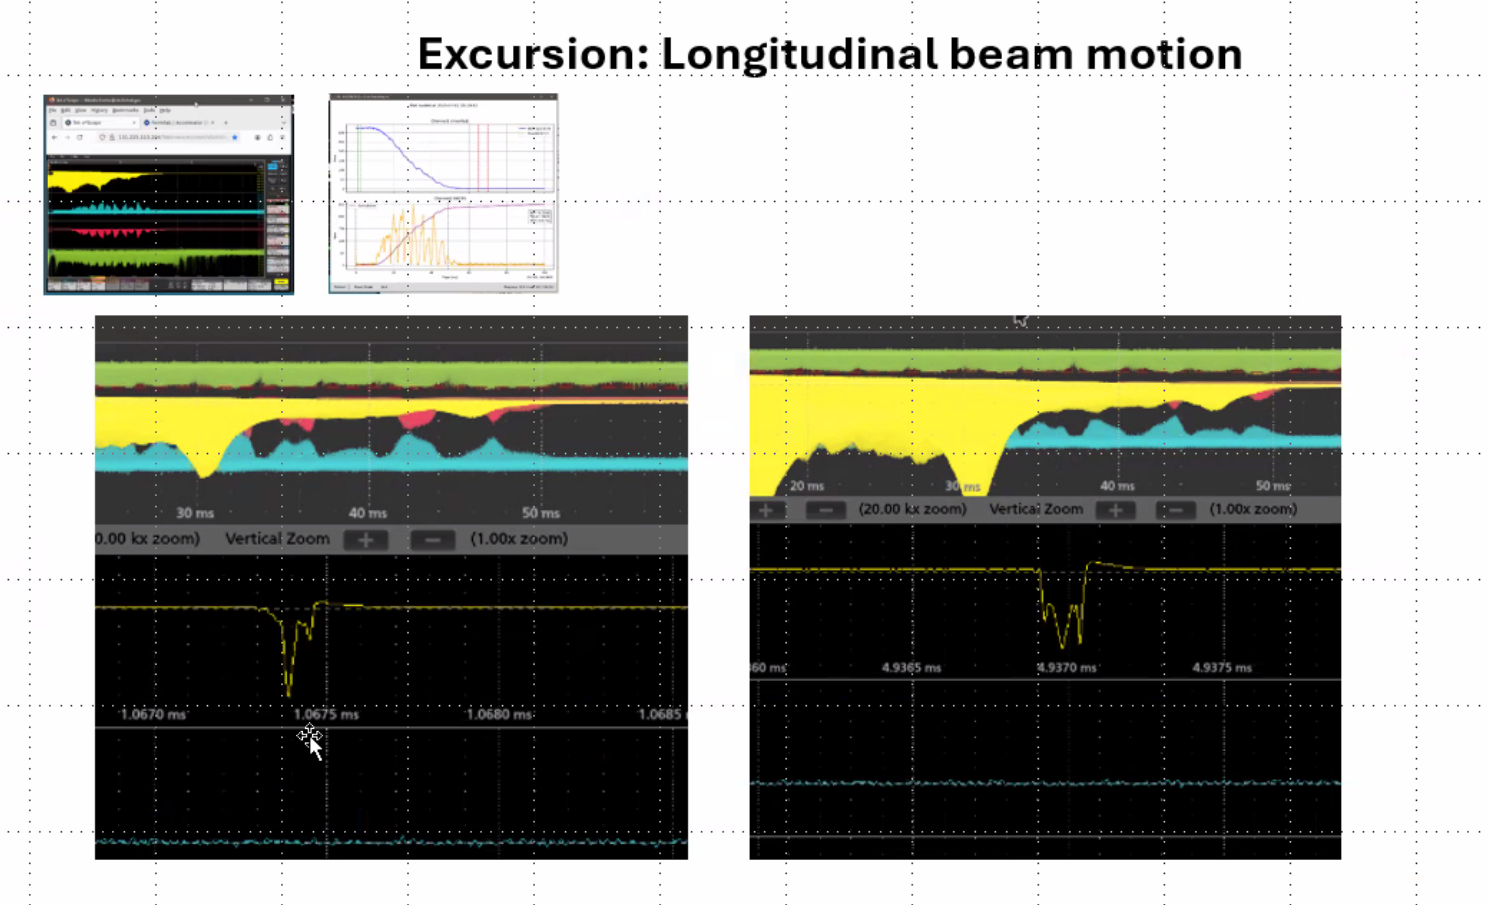
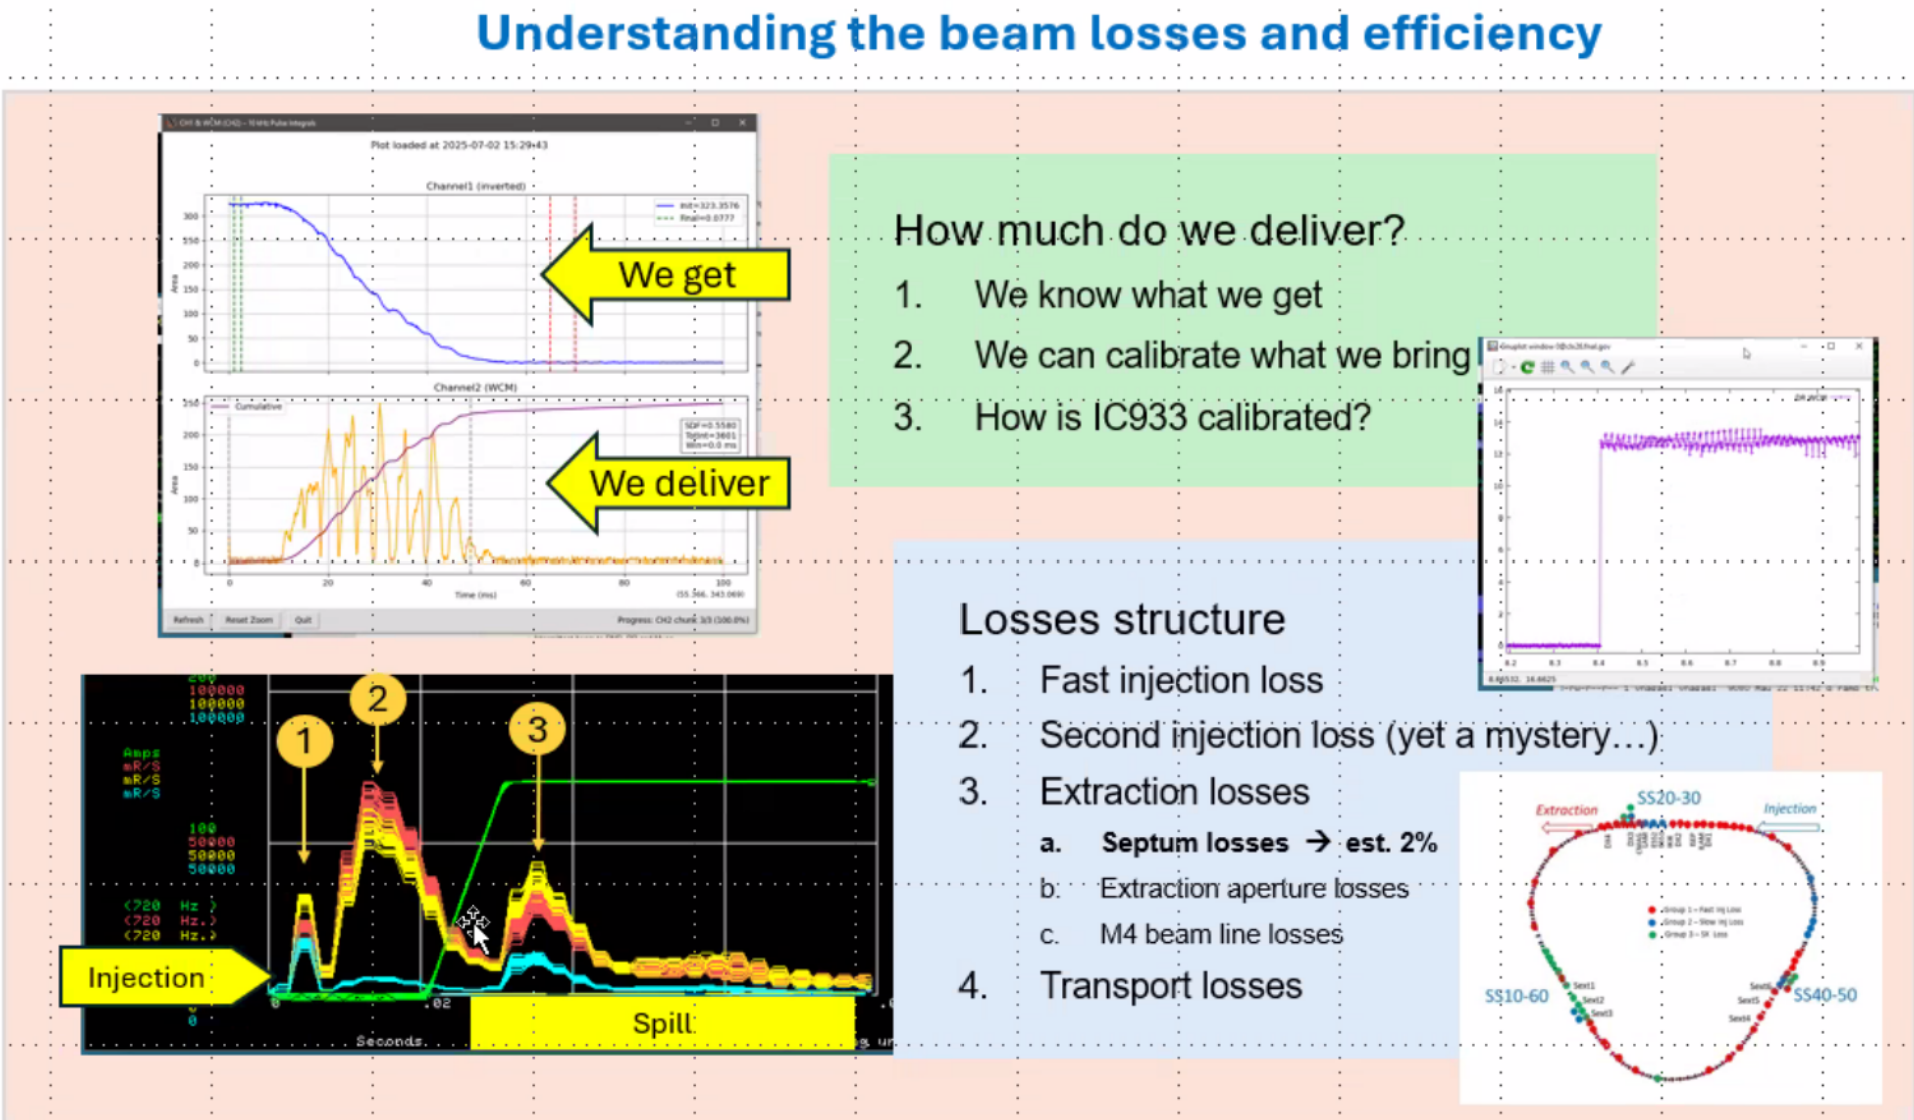

In [ ]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################
from extinction_plots import plot_2d_histogram_delta_train

for channel, delta_train in enumerate(delta_trains):
    plot_2d_histogram_delta_train(delta_train, period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hc.folder_name}/2d_histogram_uncorrected.png",
                                  bin_width_ns = 12,
                                  n_slices=40,
                                  figsize=(8, 4), colors = ['inferno'],
                                  title=f"2D Histogram (uncorrected for mean and period errors) [{channel + 1}]")


In [ ]:
# #######################################################
# Pulse Centering
# #######################################################
from extinction_functions import center_pulses

# period = 1694.943 ... 0284359757
# new_period = 1694.933 0284359758
# new_period = period - 0.01

# normalize delta train by detected period once, but we will slightly nudge it to make it better now
normalized_delta_trains = []
for i, delta_train in enumerate(delta_trains):
    s = symmetric_mod(delta_train, period)
    print(f"[CH{i+1}] Normalized delta train mean: {s.mean():.3f} ns, ")
    normalized_delta_trains.append(s)
new_detected_period = period

# Plot histogram normalized by FFT period
plot_normalized_histogram(delta_trains, normalized_delta_trains, period, figsize=(10, 5),
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_normalized_histogram.svg",
                          title=f"Period-Modulated Histogram (without mean and period corrections)", log=True)

new_delta_trains, new_period, correction_to_mean = center_pulses(delta_trains, period)
normalized_delta_trains = [symmetric_mod(delta_train, new_period) for delta_train in new_delta_trains]

common_title_text = re.sub(r' - Channel \d', '', common_title_text)  # remove channel number from title

In [ ]:
# Plot histogram normalized by FFT period
plot_normalized_histogram(new_delta_trains, normalized_delta_trains, new_period,
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_corrected_normalized_histogram.svg",
                          figsize=(10, 5), log=False, bin_count=200,
                          title = "Period-Modulated Histogram")

# Plot histogram normalized by FFT period
plot_normalized_histogram(new_delta_trains, normalized_delta_trains, new_period,
                          file_name=f"img/{hc.folder_name}/{hc.file_name}_corrected_normalized_histogram.svg",
                          figsize=(10, 5), log=True, symlog=False, bin_count=200,
                          title = "Period-Modulated Histogram")

In [ ]:
t_range_begin_ns = 0
# t_range = (t_range_begin_ns, t_range_begin_ns + 1695*50)
t_range = (0, 100.e6)
delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=1,
                                                                        fft_time_range_ns=t_range)

means = []
normalized_delta_trains_per_event = []

for delta_train in delta_trains_per_event:
    d: np.ndarray = symmetric_mod(delta_train, new_period).astype(float)
    means.append(np.mean(d))

total_mean = np.mean(means)
normalized_delta_trains_per_event = [symmetric_mod(d - total_mean, new_period) for d in delta_trains_per_event]
print(f"Adjusted delta train mean by {total_mean:.3f} ns")

plot_2d_histogram_time_vs_event_number(
    normalized_delta_trains_per_event,
    bin_width = 4,
    units='ns',
    t_range = (-900, 900),
    # t_range=t_range
)

In [ ]:
# Check this plot again after period and mean corrections
start = 15e6
start = start - start % new_period - 500
end = start + new_period * 6
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=0.7, bin_size_ns=36,
                  fig_size = (12, 4), sample_offset = 500, legend=True,
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms",
                  file_name=f"img/{hc.folder_name}/{hc.file_name}_zoomed_corrected_1d_histogram.svg",
                  units="ns")

end = start + new_period * 4.5
plot_1d_histogram(new_delta_trains, common_title_text=common_title_text, include_sample_peaks=True, sample_offset=500,
                  sample_period=new_period, hist_range=(start, end), loc="upper right", alpha=1, bin_size_ns=24,
                  fig_size=(10, 4), legend=True,
                  # file_name=f"img/{hex_check.folder_name}/zoomed_histogram.png",
                  file_name=f"img/{hc.folder_name}/MOP037_f4.png",
                  title=f"Selective Zoom-In - Time Range: {start * 1e-6:.3f} to {end * 1e-6:.3f} ms")

In [ ]:
# #######################################################
# PLOT 2D HISTOGRAM
# #######################################################

# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#
# plot_2d_histogram_delta_train(delta_trains[2], period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 1,
#                               colors=['Reds'], bin_width_ns = 4,
#                               n_slices=125, alpha=1,
#                               title = f"2D Histogram, before/after corrections",
#                               )
#
# plot_2d_histogram_delta_train(new_delta_trains[2], new_period, common_title_text=common_title_text,
#                               channel = 3, fig_ax = (fig, ax), subplot_no = 2,
#                               colors=['Greens'], bin_width_ns = 4,
#                               n_slices=125, alpha=0.5,
#                               )
#
# plt.tight_layout()
# plt.savefig(f"img/{hc.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.savefig(f"img/{hc.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight',
#             pad_inches=0)
# plt.show()

for channel, new_delta_train in enumerate(new_delta_trains):
    plot_2d_histogram_delta_train(new_delta_train, new_period, common_title_text=common_title_text,
                                  channel = channel + 1,
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                                  file_name=f"img/{hc.folder_name}/2d_histogram_corrected.png",
                                  colors=['inferno'],
                                  n_slices=40,
                                  figsize=(10, 8),
                                  title=f"2D Histogram (Channel {channel + 1})",
                                  )

all_trains = []
all_trains = np.concatenate(new_delta_trains)  # combine all delta trains into one
plot_2d_histogram_delta_train(all_trains, new_period, common_title_text=common_title_text,
                              channel = 1,
                              # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_corrected_2d_histogram_ch{channel+1}.svg",
                              file_name=f"img/{hc.folder_name}/2d_histogram_corrected.png",
                              colors=['Blues'],
                              n_slices=125, bin_width_ns=4,
                              figsize=(8, 4),
                              title="2D Histogram (All Channels Combined)",
                              )


In [ ]:
from socketudp.extinction_plots import plot_2d_histogram_delta_train_compare
#
# fig, ax = plt.subplots(1, 1, figsize=(9.5, 4))
# plot_2d_histogram_delta_train_compare(
#     before_delta=delta_trains[2],
#     after_delta=new_delta_trains[2],
#     before_period_ns=period,
#     after_period_ns=new_period,      # or period; both are fine as long as one is used for binning
#     common_title_text=common_title_text,
#     fig_ax=(fig, ax),
#     bin_width_ns=4,
#     n_slices=125,
#     mode="ratio",                         # "diff" or "ratio"
#     title="2D Histogram: after – before (Δcounts)",
# )
# plt.tight_layout()
# plt.savefig(f"img/{hc.folder_name}/2d_hist_comparison.svg", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig(f"img/{hc.folder_name}/MOP037_f6.png", dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()




In [ ]:
# #######################################################
# EXTINCTION MEASUREMENT
# #######################################################

for i, normalized_delta_train in enumerate(normalized_delta_trains):
    # define +/- 125 ns window as "in-time", and everything else as "out-of-time"
    in_time_counts = np.sum(np.abs(normalized_delta_train) <= 125)
    out_of_time_counts = len(normalized_delta_train) - in_time_counts
    print(f"[CH{i+1}] In-time counts: {in_time_counts}, Out-of-time counts: {out_of_time_counts}")
    extinction_ratio = out_of_time_counts / (in_time_counts + out_of_time_counts)
    print(f"[CH{i+1}] Extinction ratio: {extinction_ratio:.3e} (out-of-time / total counts)")


In [ ]:
# ############################
# THREE FOLD COINCIDENCE
# ############################

average_points = get_three_fold_coincidence_points(new_delta_trains,
                                                   coincidence_window_ns=300)

# average points is now a simple list of timestamps, plot on a histogram
if average_points.size > 0:
    three_fold_title = re.sub(r"\nTime Range: .*? ms", "", common_title_text)
    plt.figure(figsize=(10, 5))
    plt.hist(average_points / 1e6, bins=100, color='purple', alpha=0.7)
    plt.xlabel("Time (ms)")
    plt.ylabel("Counts")
    plt.title("Three-Fold Coincidence Histogram")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------

    fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    # Plot two-part combined 2D histogram with disjointed time-axis in same figure
    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[1]), subplot_no = 2,
                                  common_title_text="Three-Fold Coincidence Events)",
                                  colors=['inferno'],
                                  file_name=f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=True, t_range=(0, 2e9))

    plot_2d_histogram_delta_train(average_points, new_period, fig_ax = (fig, ax[0]), subplot_no = 1,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'], file_name=f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram.svg", n_slices=120,
                                  figsize=(6, 8), textbox=True, t_range=(13.5e6, np.inf))

    file_name = f"img/{hc.folder_name}/{hc.file_name}_three_fold_coincidence_2d_histogram_combined.svg"
    if file_name:
        plt.savefig(file_name, dpi=300)
    plt.show()

    # ------------------------------------------------------------------
    # plot individual histograms of chosen times
    plot_2d_histogram_delta_train(average_points, new_period,
                                  common_title_text="Three-Fold Coincidence Events",
                                  colors=['inferno'],
                                  # file_name=f"img/{hex_check.folder_name}/{hex_check.file_name}_three_fold_coincidence_2d_histogram.svg",
                                  n_slices=80,
                                  figsize=(10, 6), textbox=True, t_range=(0, 2e6))
    plot_2d_histogram_delta_train(average_points, new_period,
                              common_title_text="Three-Fold Coincidence Events",
                              colors=['inferno'], n_slices=120,
                              figsize=(8, 4), textbox=True, t_range=(13.5e6, np.inf))

In [ ]:
# modulated version of three-fold coincidence plot

for i in range(4):
    delta_trains_per_event, fft_time_range_ns_2 = get_delta_train_per_event(channel=i+1,
                                                                            fft_time_range_ns=(5e6, 100e6),
                                                                            period=period)
    print(f"[CH{i+1}] Received {len(delta_trains_per_event)} delta trains")

    # skip if no data
    if len(delta_trains_per_event) == 0:
        continue

    # subtract mean out
    means = []
    for i in delta_trains_per_event:
        if len(i) == 0:
            continue
        means.append(np.mean(i))

    total_mean = np.mean(means)
    new_delta_trains_per_event = []
    for i in delta_trains_per_event:
        new_delta_trains_per_event.append(symmetric_mod(np.array(i) - total_mean, period))


    plot_2d_histogram_time_vs_event_number(
        new_delta_trains_per_event,
        bin_width = 10,
        units='ns',
        t_range=(-900, 900),
        binrange=(-900, 900)
    )